# Setup

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, Model
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical

# Data loading

In [2]:
# Loading training and test data
with open('data/emnist_train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('data/emnist_test.pkl', 'rb') as f:
    test_data = pickle.load(f)

x_train = train_data['data']
y_train = train_data['labels']

x_test = test_data['data']
y_test = test_data['labels']

print("Training data:", x_train.shape)
print("Training labels:", y_train.shape)
print("Test data:", x_test.shape)
print("Test labels:", y_test.shape)

Training data: (100000, 28, 28)
Training labels: (100000,)
Test data: (20000, 28, 28)
Test labels: (20000,)


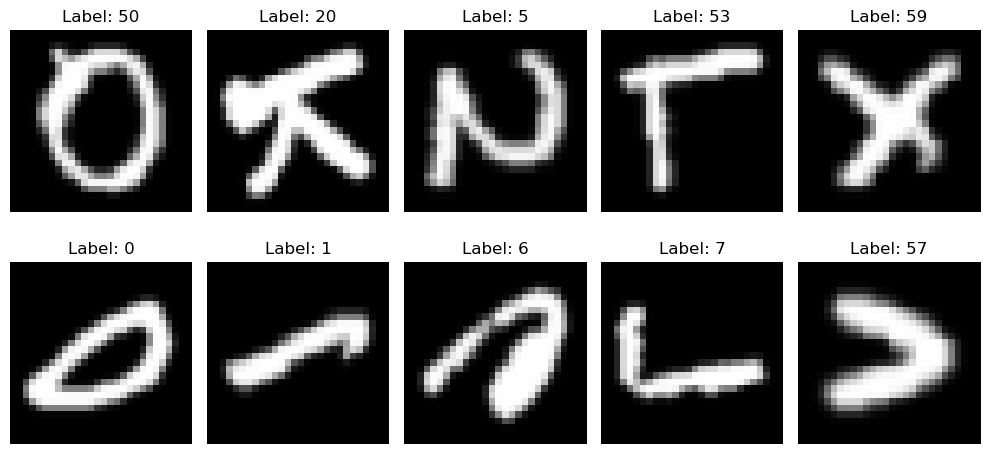

In [3]:
# show some data
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2 rows and 5 columns displaying 10 images

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap='gray')  # Display the ith image, using greyscale colour mapping
    ax.set_title(f"Label: {y_train[i]}")  # Showing corresponding tags
    ax.axis('off')  # no axes

plt.tight_layout()  
plt.show() 

# pre-processing

In [4]:
# 1. Normalize the training and test data 
x_train = x_train / 255.0
x_test = x_test / 255.0

# 2. Reshape training and test data for grayscale
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# 3. split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# show the results
print(f"Training sets: {x_train.shape}")
print(f"Validation sets: {x_val.shape}")


Training sets: (80000, 28, 28, 1)
Validation sets: (20000, 28, 28, 1)


# Model Implementation

In [5]:
class vit(Model):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout):
        super(vit, self).__init__()

        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = patch_size * patch_size

        # Layers for patch embedding
        self.patch_embedding = layers.Dense(dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches + 1, output_dim=dim)
        self.cls_token = tf.Variable(tf.zeros([1, 1, dim]), trainable=True)

        # Transformer layers
        self.transformer_layers = [
            layers.MultiHeadAttention(num_heads=heads, key_dim=dim, dropout=dropout) for _ in range(depth)
        ]
        self.norm_layers = [layers.LayerNormalization(epsilon=1e-6) for _ in range(depth)]
        self.mlp_layers = [tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(dim),
            layers.Dropout(dropout)
        ]) for _ in range(depth)]

        # Classification head
        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(num_classes)
        ])

    def call(self, x):
        # Create patches
        batch_size = tf.shape(x)[0]
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, 4, 4, 1],
            strides=[1, 4, 4, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(patches, [batch_size, -1, 4 * 4])  # Flatten patches

        # Apply patch embedding
        x = self.patch_embedding(patches)

        # Add class token and position embedding
        cls_tokens = tf.repeat(self.cls_token, repeats=batch_size, axis=0)
        x = tf.concat([cls_tokens, x], axis=1)
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        x += self.position_embedding(positions)

        # Transformer blocks
        for norm_layer, transformer_layer, mlp_layer in zip(self.norm_layers, self.transformer_layers, self.mlp_layers):
            x = norm_layer(x)
            x = transformer_layer(x, x) + x
            x = mlp_layer(x) + x

        # Classification token
        x = x[:, 0]
        return self.mlp_head(x)



In [9]:
def build_vit_model(image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout):
    model = vit(image_size=image_size, 
                patch_size=patch_size, 
                num_classes=num_classes, 
                dim=dim, 
                depth=depth, 
                heads=heads, 
                mlp_dim=mlp_dim, 
                dropout=dropout)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
                  metrics=['accuracy'])
    return model
    

In [10]:
num_classes = len(set(y_train))
test_model = build_vit_model(image_size=28, patch_size=4, num_classes=num_classes, dim=64, depth=4, heads=4, mlp_dim=128, dropout=0.1)

test_model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
1250/1250 [==============================] - 18s 13ms/step - loss: 1.6305 - accuracy: 0.5465 - val_loss: 0.9494 - val_accuracy: 0.7034
Epoch 2/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.8701 - accuracy: 0.7234 - val_loss: 0.7018 - val_accuracy: 0.7618
Epoch 3/10
1250/1250 [==============================] - 16s 12ms/step - loss: 0.7227 - accuracy: 0.7623 - val_loss: 0.6350 - val_accuracy: 0.7838
Epoch 4/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6541 - accuracy: 0.7793 - val_loss: 0.5900 - val_accuracy: 0.7931
Epoch 5/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.6098 - accuracy: 0.7925 - val_loss: 0.5809 - val_accuracy: 0.7982
Epoch 6/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.5786 - accuracy: 0.8012 - val_loss: 0.5412 - val_accuracy: 0.8121
Epoch 7/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5527 - accuracy: 0.8093 - val_loss: 0.5472 -

In [11]:
train_loss, train_accuracy = test_model.evaluate(x_train, y_train)
val_loss, val_accuracy = test_model.evaluate(x_val, y_val)

print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

625/625 [==============================] - 4s 6ms/step - loss: 0.5108 - accuracy: 0.8225
Train Loss: 0.4515, Train Accuracy: 0.8377
Validation Loss: 0.5108, Validation Accuracy: 0.8225


# Hyperparameter Tunning

In [16]:
model = KerasClassifier(build_fn=build_vit_model, epochs=5, batch_size=64, verbose=0)
param_dist = {
    'image_size': [28],
    'patch_size': [2, 4, 7],
    'num_classes':[62],
    'dim': [32, 64, 128],
    'depth': [4, 6, 8],
    'heads': [4, 8],
    'mlp_dim': [64, 128, 256],
    'dropout': [0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3
)

C:\Users\F0rR1ver\AppData\Local\Temp\ipykernel_540\3519229459.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_vit_model, epochs=5, batch_size=64, verbose=0)


In [17]:
random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

834/834 [==============================] - 9s 10ms/step
Best Parameters: {'patch_size': 2, 'num_classes': 62, 'mlp_dim': 256, 'image_size': 28, 'heads': 8, 'dropout': 0.3, 'dim': 32, 'depth': 4}
Best Score: 0.7638999408629794


In [25]:
best_params = {'patch_size': 2, 'num_classes': 62, 'mlp_dim': 256, 'image_size': 28, 'heads': 8, 'dropout': 0.3, 'dim': 32, 'depth': 4}

final_model = build_vit_model(
    image_size=best_params['image_size'],
    patch_size=best_params['patch_size'],
    num_classes=best_params['num_classes'],
    dim=best_params['dim'],
    depth=best_params['depth'],
    heads=best_params['heads'],
    mlp_dim=best_params['mlp_dim'],
    dropout=best_params['dropout']
)

history = final_model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=30,  
    validation_data=(x_val, y_val)
)

test_loss, test_accuracy = final_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30
1250/1250 [==============================] - 19s 14ms/step - loss: 2.2822 - accuracy: 0.3882 - val_loss: 1.4381 - val_accuracy: 0.5849
Epoch 2/30
1250/1250 [==============================] - 17s 14ms/step - loss: 1.2029 - accuracy: 0.6377 - val_loss: 0.9884 - val_accuracy: 0.6879
Epoch 3/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.9307 - accuracy: 0.7055 - val_loss: 0.8186 - val_accuracy: 0.7333
Epoch 4/30
1250/1250 [==============================] - 16s 13ms/step - loss: 0.8052 - accuracy: 0.7406 - val_loss: 0.7162 - val_accuracy: 0.7639
Epoch 5/30
1250/1250 [==============================] - 17s 14ms/step - loss: 0.7346 - accuracy: 0.7613 - val_loss: 0.6948 - val_accuracy: 0.7672
Epoch 6/30
1250/1250 [==============================] - 18s 14ms/step - loss: 0.6851 - accuracy: 0.7737 - val_loss: 0.6594 - val_accuracy: 0.7822
Epoch 7/30
1250/1250 [==============================] - 18s 14ms/step - loss: 0.6489 - accuracy: 0.7832 - val_loss: 0.6275 -

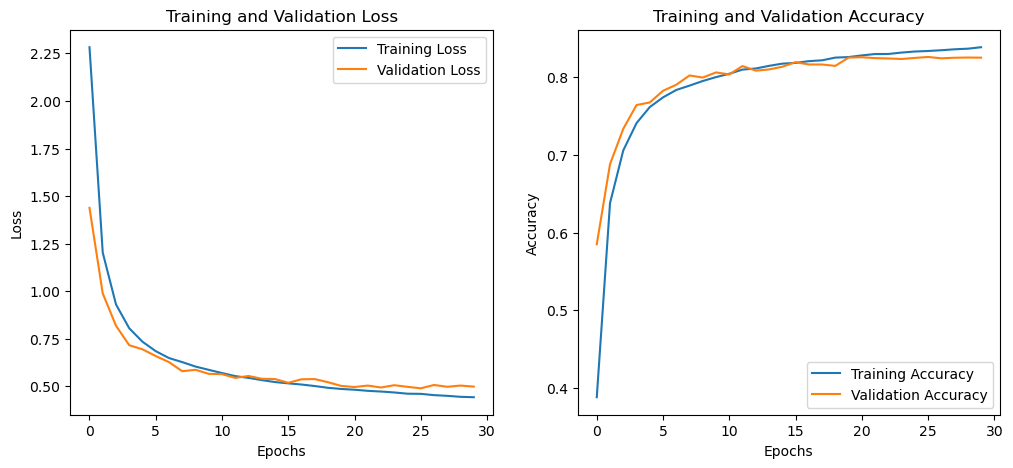

In [26]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.show()

plot_history(history)


In [28]:
from sklearn.metrics import accuracy_score
# 使用最佳参数训练好的模型对测试集进行预测
y_pred_vit = final_model.predict(x_test)

# 获取预测类别
y_pred_vit_classes = np.argmax(y_pred_vit, axis=1)

# 将测试标签转换为类别形式（整数标签）
y_test_classes = y_test  # 如果 y_test 已经是整数标签

# 计算准确率
accuracy_vit = accuracy_score(y_test_classes, y_pred_vit_classes)
print(f"ViT Test Accuracy: {accuracy_vit:.4f}")

625/625 [==============================] - 2s 3ms/step
ViT Test Accuracy: 0.8264
